# Dataset

  **Cardiotocography**

  Data set related to heart diseases. It describes 3 classes: normal, suspect, or pathological. Normal patients are treated as inliers and the remaining as outliers. 

  There is no proper description with this particular dataset, so I took the fileds description from different cardiotocography set:

*   LB: FHR baseline
*   AC: accelerations
*   FM: fetal movements 
*   UC: uterine contractions
*   ASTV: percentage of time with abnormal short term variability
*   MSTV: mean value of short term variability
*   ALTV: percentage of time with abnormal long term variability 
*   MLTV: mean value of long term variability
*   DL: light decelerations
*   DS: severe decelerations
*   DP: prolongued decelerations
*   Width: histogram width
*   Min: low freq. of the histogram
*   Max: high freq. of the histogram 
*   Nmax: number of histogram peaks
*   Nzeros: number of histogram zeros
*   Mode: histogram mode
*   Mean: histogram mean
*   Median: histogram median
*   Variance: histogram variance
*   Tendency: histogram tendency

I don't have an idea what `id` column means here. It is not unique. Do we have multiple observations for the same patient? 

# EDA

## Import

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
!pip3 install pandas_profiling --upgrade
import pandas_profiling

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from statsmodels.graphics.mosaicplot import mosaic

import missingno as msno
!pip install robustats
import robustats

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#!pip install umap-learn
#import umap.umap_ as umap


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from imblearn.over_sampling import SMOTE

### sklearn

In [4]:
from sklearn.ensemble import IsolationForest

from sklearn.preprocessing import StandardScaler, LabelEncoder, \
              QuantileTransformer, PowerTransformer, PolynomialFeatures
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import calinski_harabasz_score, adjusted_rand_score,\
       adjusted_mutual_info_score, silhouette_score, silhouette_samples,\
       make_scorer, homogeneity_score, completeness_score, v_measure_score,\
       davies_bouldin_score, f1_score, precision_score, recall_score, accuracy_score,\
       classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, \
  RandomizedSearchCV, GridSearchCV, cross_validate, KFold, RepeatedStratifiedKFold, \
  cross_val_score

from sklearn.linear_model import LogisticRegression, \
        SGDOneClassSVM    

from sklearn.neighbors import KNeighborsClassifier                                 

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline                                    

## Data reading

Let's import the dataset and see its overall structure

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/Myoth13/datasets/main/Cardiotocography.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16880 entries, 0 to 16879
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        16880 non-null  float64
 1   LB        16880 non-null  float64
 2   AC        16880 non-null  float64
 3   FM        16880 non-null  float64
 4   UC        16880 non-null  float64
 5   ASTV      16880 non-null  float64
 6   MSTV      16880 non-null  float64
 7   ALTV      16880 non-null  float64
 8   MLTV      16880 non-null  float64
 9   DL        16880 non-null  float64
 10  DS        16880 non-null  float64
 11  DP        16880 non-null  float64
 12  Width     16880 non-null  float64
 13  Min       16880 non-null  float64
 14  Max       16880 non-null  float64
 15  Nmax      16880 non-null  float64
 16  Nzeros    16880 non-null  float64
 17  Mode      16880 non-null  float64
 18  Mean      16880 non-null  float64
 19  Median    16880 non-null  float64
 20  Variance  16880 non-null  fl

In [6]:
df.head()

,id,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,outlier
0,1881.0,0.592593,0.000000,0.000000,0.294118,0.633803,0.338235,0.000000,0.013807,0.500000,0.0,0.000000,0.595376,0.045872,0.336207,0.333333,0.1,0.485149,0.247423,0.284091,0.638418,1.0,b'yes'
1,421.0,0.574074,0.038462,0.000000,0.000000,0.816901,0.029412,0.527473,0.092702,0.000000,0.0,0.000000,0.364162,0.770642,0.672414,0.166667,0.0,0.534653,0.587629,0.511364,0.016949,0.0,b'yes'
2,92.0,0.777778,0.000000,0.000000,0.000000,0.774648,0.029412,0.736264,0.096647,0.000000,0.0,0.000000,0.069364,0.816514,0.275862,0.222222,0.0,0.633663,0.659794,0.602273,0.000000,1.0,b'yes'
3,1767.0,0.259259,0.000000,0.000000,0.294118,0.704225,0.191176,0.000000,0.183432,0.428571,0.0,0.333333,0.473988,0.174312,0.275862,0.222222,0.1,0.000000,0.164948,0.000000,0.361582,0.0,b'yes'
4,1880.0,0.592593,0.000000,0.001773,0.294118,0.633803,0.352941,0.000000,0.013807,0.428571,0.0,0.333333,0.595376,0.045872,0.336207,0.333333,0.1,0.485149,0.226804,0.272727,0.683616,1.0,b'yes'


It is not obvious how null values are encoded if they are present, so I will assume for now that we have no data missing or it is imputed with 0

## Data range constrains

In [7]:
df.describe()

,id,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
count,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000
mean,1123.872156,0.483186,0.129270,0.011411,0.226668,0.425672,0.179521,0.064739,0.170819,0.113227,0.000770,0.017417,0.391083,0.379411,0.365604,0.230579,0.033365,0.563887,0.525497,0.475086,0.090984,0.670794
std,593.610901,0.175738,0.143077,0.060514,0.156665,0.216970,0.121198,0.146732,0.114551,0.171935,0.027742,0.084956,0.214992,0.252147,0.153285,0.159211,0.069209,0.128429,0.136375,0.146790,0.119737,0.295171
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,641.000000,0.351852,0.000000,0.000000,0.117647,0.236111,0.088235,0.000000,0.094675,0.000000,0.000000,0.000000,0.204678,0.155963,0.258621,0.111111,0.000000,0.482143,0.431193,0.373494,0.015385,0.500000
50%,1150.500000,0.481481,0.076923,0.000000,0.235294,0.408451,0.161765,0.000000,0.155819,0.000000,0.000000,0.000000,0.377907,0.376147,0.353448,0.222222,0.000000,0.567797,0.525773,0.478261,0.045198,0.500000
75%,1619.000000,0.592593,0.192308,0.003546,0.304348,0.608108,0.220588,0.050633,0.226824,0.214286,0.000000,0.000000,0.549133,0.596330,0.456897,0.333333,0.000000,0.650000,0.621053,0.576087,0.122677,1.000000
max,2126.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can see that all the fields has 1 as a max value, which may indicate an issue. There is no proper description of the dataset available, unfortunately. So we can surmize only from the distributions. 

## Constants and useless fields

Checking for useless data and constans

In [8]:
(df.nunique()/len(df)).sort_values(ascending=False)

id          0.112678
Width       0.059953
Median      0.039040
Mean        0.028199
Variance    0.025355
Mode        0.021505
ALTV        0.016825
ASTV        0.016706
MLTV        0.014751
Min         0.006457
FM          0.005154
Max         0.005036
MSTV        0.003258
LB          0.002844
UC          0.002073
DL          0.001540
AC          0.001303
Nmax        0.001066
Nzeros      0.000533
DP          0.000296
Tendency    0.000178
DS          0.000118
outlier     0.000118
dtype: float64

We can see that there is no values close to 1 that means we do not have useless fields.

In [9]:
df.var().sort_values(ascending=True)[0:5]

DS        0.000770
FM        0.003662
Nzeros    0.004790
DP        0.007217
MLTV      0.013122
dtype: float64

We can see here that we don't have zero variance fields which means we don't have constans

## Data uniqueness

Let's check for duplicates

In [10]:
df.duplicated().sum()

0

we can see here that we have no duplicated records.

## Data type constrains
As we can see from previous analysis all independent variables are numeric that is perfect for our analysis

## Independent variables

Let's see the stat



In [11]:
profile = pandas_profiling.ProfileReport(df)
profile.to_file('profile.html')
display(profile)

Output hidden; open in https://colab.research.google.com to view.

From the profile report we can see a few problems:

*   Disrtibutions of some variables are not normal
*   Some highly correlated features

Let's deal with each of the feaures separately

In [12]:
pow = PowerTransformer()

### LB

The experimental data visualization revealed the following findings. When the values of AC, UC and MSTV increased, the fetal status tended to be normal. In contrast, when the values of ASTV, ALTV, DP and LB increased, the fetus was more likely to be pathological. Figure 3 illustrates two instances. Firstly, the baseline (LB) values in the normal cases were mostly at the interval of 111–120 bpm, while the numbers of suspicious and pathology cases increased with baseline values. Secondly, the proportion of pathology cases increased with ASTV, whereas that of normal reversed; when ASTV value ranged from 0 to 18, the proportion of normal category reached 100%; as the ASTV value exceeded 80, the proportion of pathological cases increased significantly. Overall, twelve CTG features symbolized as AC, UC, LB, FM, DP, ASTV, ALTV, MLTV, Mode, Mean, Min, and Median were closely related to the fetal status.

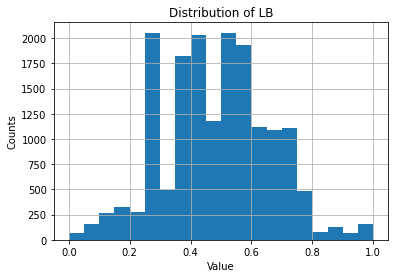

In [13]:
df.LB.hist(bins=20)
plt.title('Distribution of LB')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.show()

Shape is OK

### AC

accelerations (SisPorto)

Accelerations are short-term rises in the heart rate of at least 15 beats per minute, lasting at least 15 seconds. 

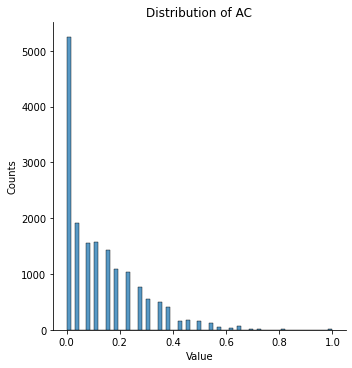

In [14]:
sns.displot(df.AC)
plt.title('Distribution of AC')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.show()

We can see that it close to exponential distribution and slightly zero-inflated. Let's try to make up shape of the distribution. There is no transformation for zero inflaed data avalable to make it look normal without loosing information.

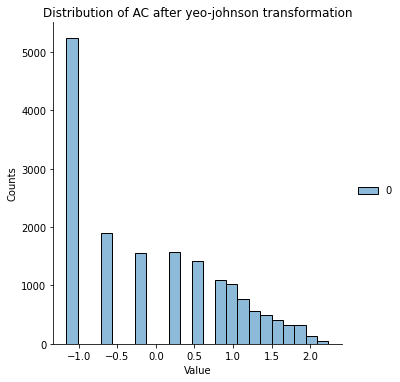

In [15]:
sns.displot(pow.fit_transform(df.AC.values.reshape(-1,1)))
plt.title('Distribution of AC after yeo-johnson transformation')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.show()

We can clearly see here two groups of the data - `AC = 0` group and with some percentages of accelerations.


 ### FM

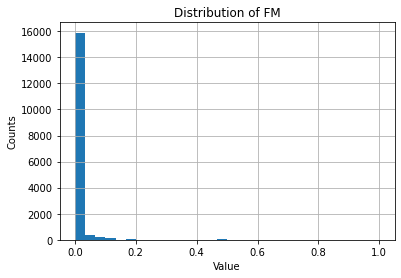

In [16]:
df.FM.hist(bins=30)
plt.title('Distribution of FM')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.show()

We can see that `FM` is zero inflated. 

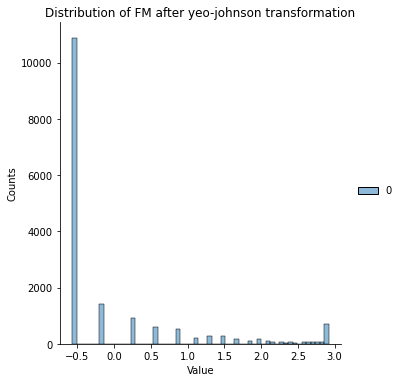

In [17]:
sns.displot(pow.fit_transform(df.FM.values.reshape(-1,1)))
plt.title('Distribution of FM after yeo-johnson transformation')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.show()

There is no point in transforming

### UC

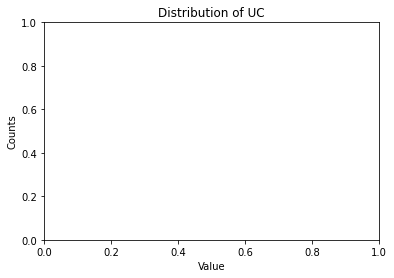

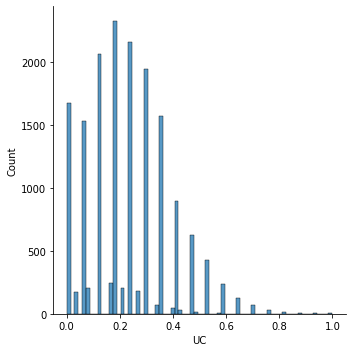

In [18]:
plt.title('Distribution of UC')
plt.xlabel('Value')
plt.ylabel('Counts')
sns.displot(df.UC)
plt.show()

We can see that the distribution is right skewed. 

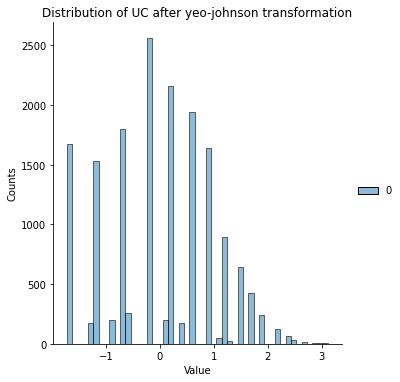

In [19]:
sns.displot(pow.fit_transform(df.UC.values.reshape(-1,1)+0.0001))
plt.title('Distribution of UC after yeo-johnson transformation')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.show()

Shape is almost the same, no point in transforming

### ASTV

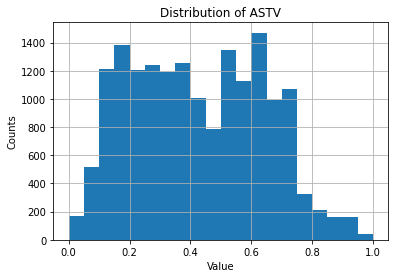

In [20]:
df.ASTV.hist(bins=20)
plt.title('Distribution of ASTV')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.show()

looks alrigt

### MSTV

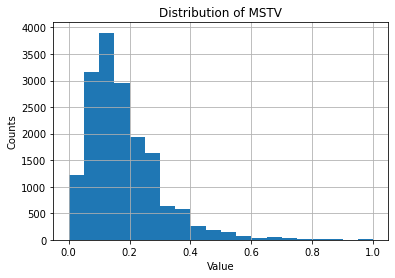

In [21]:
df.MSTV.hist(bins=20)
plt.title('Distribution of MSTV')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.show()

Distribution is right skewed

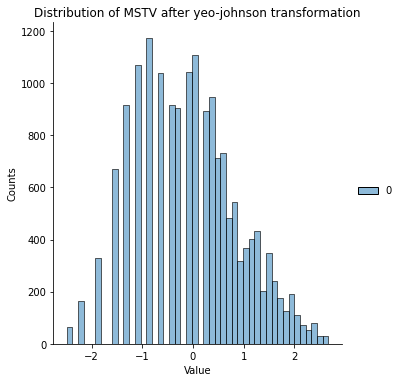

In [22]:
sns.displot(pow.fit_transform(df.MSTV.values.reshape(-1,1)))
plt.title('Distribution of MSTV after yeo-johnson transformation')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.show()

Finally something looks normal after transformation =))

### ALTV

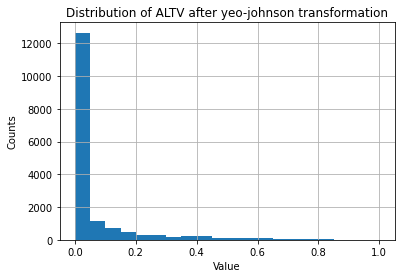

In [23]:
df.ALTV.hist(bins=20)
plt.title('Distribution of ALTV after yeo-johnson transformation')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.show()

Another zero inflated variable

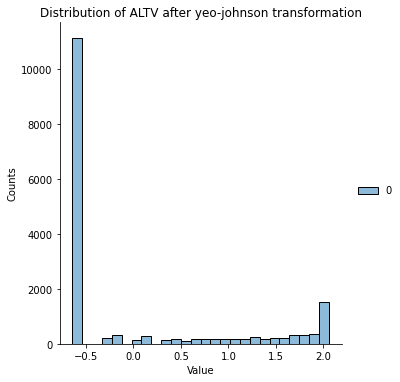

In [24]:
sns.displot(pow.fit_transform(df.ALTV.values.reshape(-1,1)))
plt.title('Distribution of ALTV after yeo-johnson transformation')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.show()

It does not show good result which is expected from highly zero inflated data, no point in transformation

### MLTV

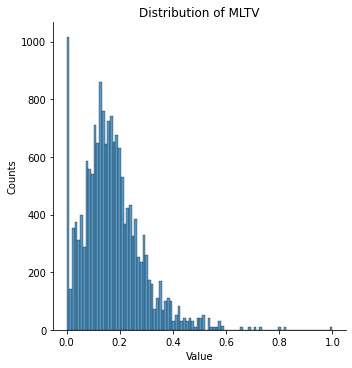

In [25]:
sns.displot(df.MLTV)
plt.title('Distribution of MLTV')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.show()

Zero inflated, right skewed

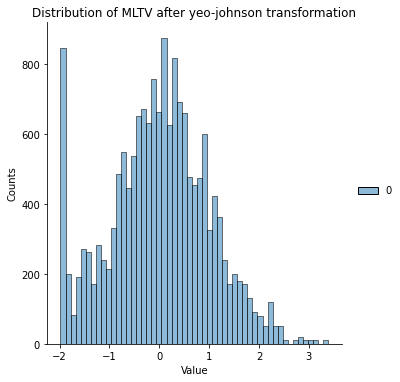

In [26]:
sns.displot(pow.fit_transform(df.MLTV.values.reshape(-1,1)))
plt.title('Distribution of MLTV after yeo-johnson transformation')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.show()

Non zero group looks normal

### DL

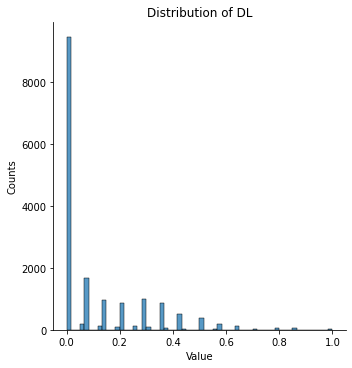

In [27]:
sns.displot(df.DL)
plt.title('Distribution of DL')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.show()

Also zero-inflated

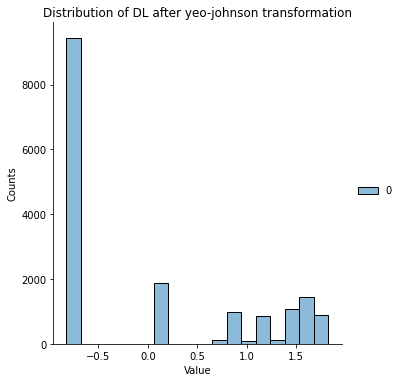

In [28]:
sns.displot(pow.fit_transform(df.DL.values.reshape(-1,1)))
plt.title('Distribution of DL after yeo-johnson transformation')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.show()

I think there is no point in transforming this variable

### DS

This is actually a categorical varible with two levels - 0 and 1. 

In [29]:
df.DS.value_counts()

0.0    16867
1.0       13
Name: DS, dtype: int64

So we have only 13 cases with severe deceletrations

### DP

This is zero inflated and discrete feature that has no point to transform 

In [30]:
df.DP.value_counts()

0.000000    16127
0.333333      572
0.500000      142
0.666667       20
1.000000       19
Name: DP, dtype: int64

### With, Min, Max

Shapes are look alright

### Nmax

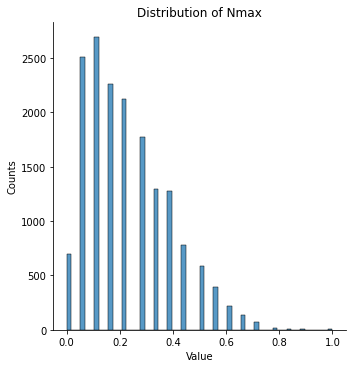

In [31]:
sns.displot(df.Nmax)
plt.title('Distribution of Nmax')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.show()

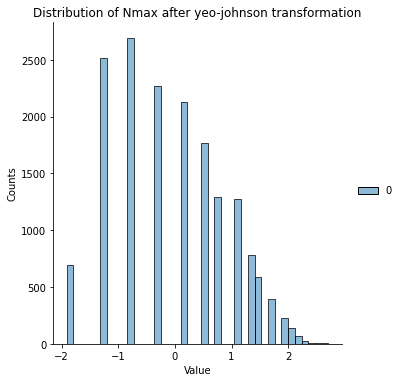

In [32]:
sns.displot(pow.fit_transform(df.Nmax.values.reshape(-1,1)))
plt.title('Distribution of Nmax after yeo-johnson transformation')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.show()

Looks a bit better

### Nzeros

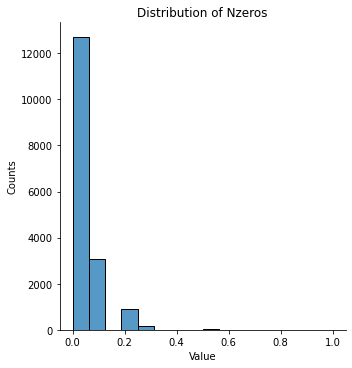

In [33]:
sns.displot(df.Nzeros)
plt.title('Distribution of Nzeros')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.show()

In [34]:
df.Nzeros.value_counts()

0.0    12704
0.1     3054
0.2      918
0.3      161
0.5       20
0.4       11
1.0       10
0.8        1
0.7        1
Name: Nzeros, dtype: int64

We can see that it is a discrete, zero inflated variable. There is no point in transformaton

### Mode, mean, median

Thanks to CLT they are normal

### Variance

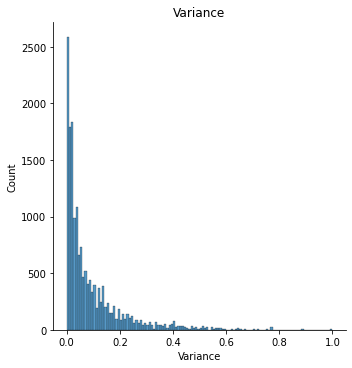

In [35]:
sns.displot(df.Variance)
plt.title('Variance')
plt.show()

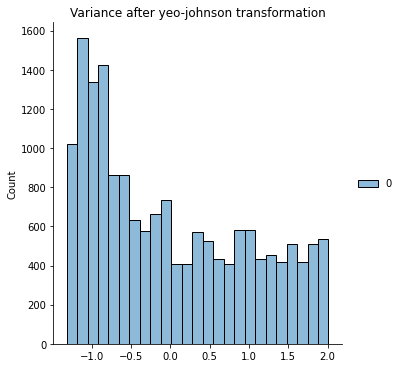

In [36]:
sns.displot(pow.fit_transform(df.Variance.values.reshape(-1,1)))
plt.title('Variance after yeo-johnson transformation')
plt.show()

Looks better

### Tendency

This a categorical variable with three levels:

In [37]:
df.Tendency.value_counts()

0.5    9028
1.0    6809
0.0    1043
Name: Tendency, dtype: int64

### List for transformation

In [38]:
trans_cols = ['AC', 'MSTV', 'MLTV', 'Variance']

## Target

We will encode target variable as catogorical and change levels

In [39]:
df.outlier = df.outlier.astype('category')
df.outlier.value_counts(normalize=True)

df['outlier'] = df.outlier.cat.rename_categories({"b'yes'": 1, "b'no'": 0})
df['outlier'].value_counts()

0    16550
1      330
Name: outlier, dtype: int64

We can see that there are only 2% of outliers in this dataset, which makes it highly imbalanced case for the supervised learning

## Distribution by target 

To see the distribution clearly I will undersample the negative class

In [40]:
df_neg_small = df[df.outlier==0].sample(df[df.outlier==1].shape[0])
df_small = pd.concat([df_neg_small,df[df.outlier==1]], axis=0)
print(df_small.shape)

(660, 23)


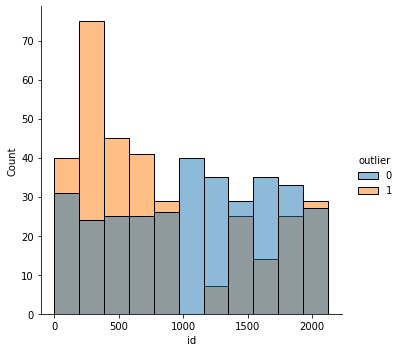

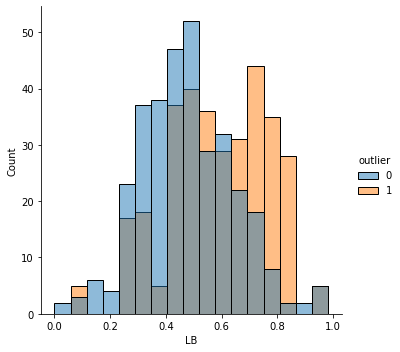

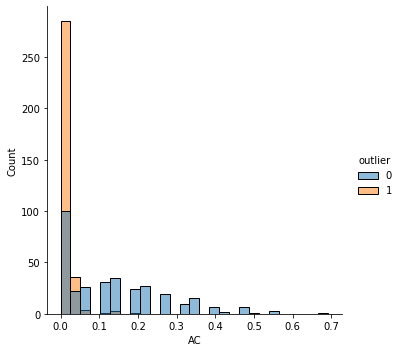

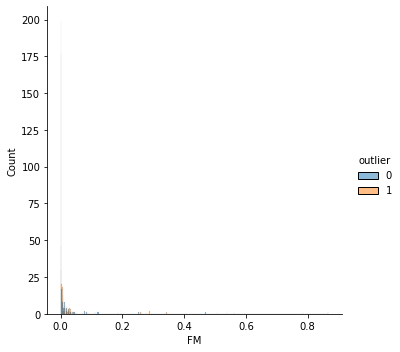

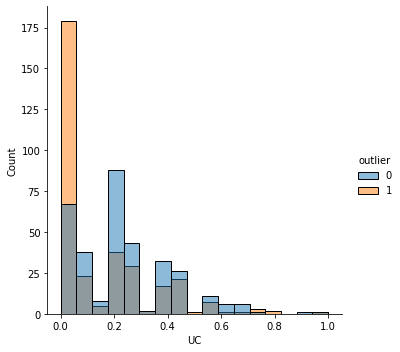

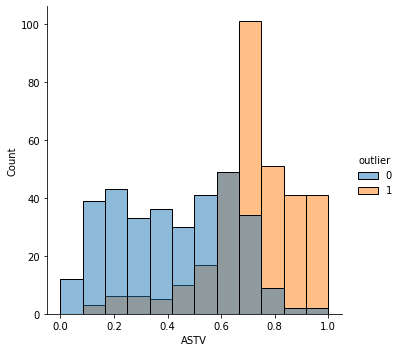

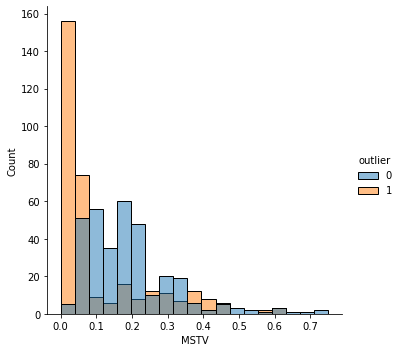

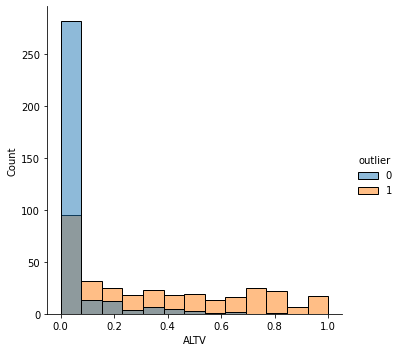

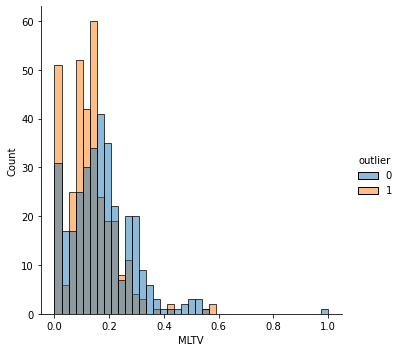

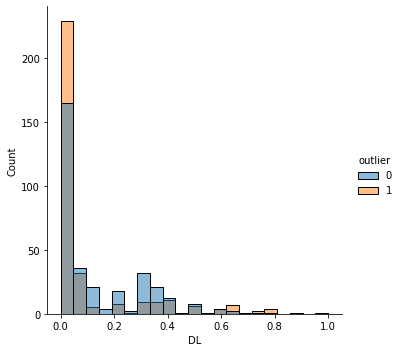

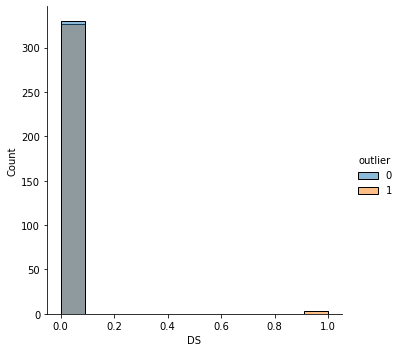

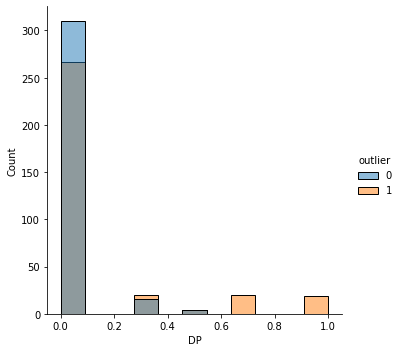

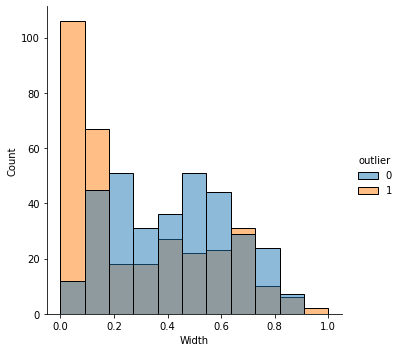

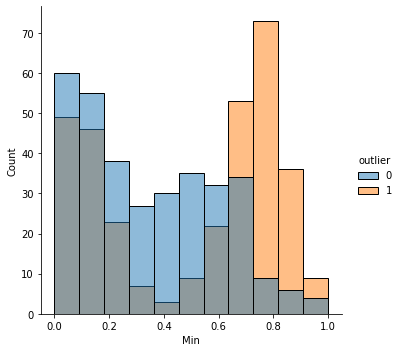

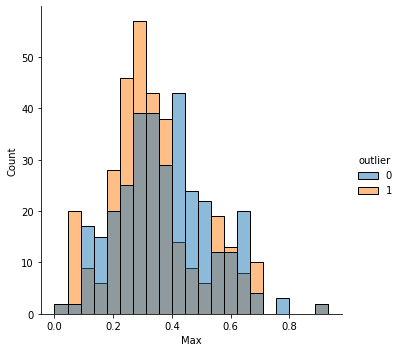

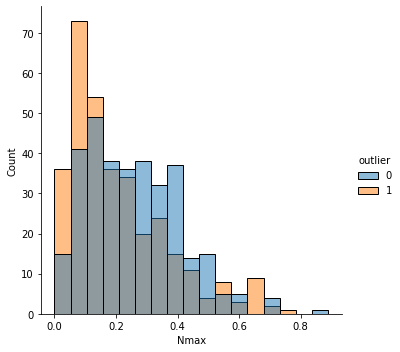

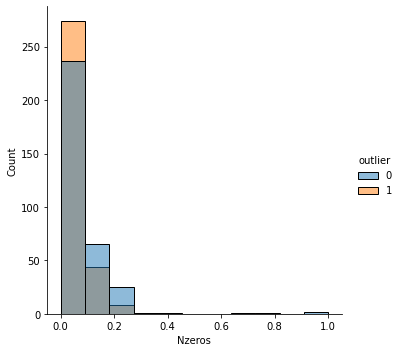

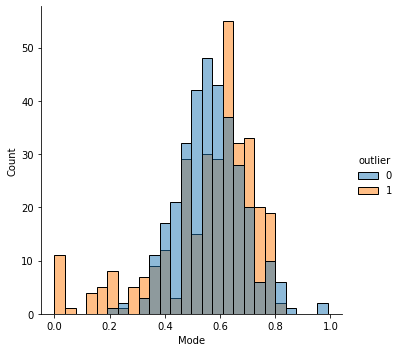

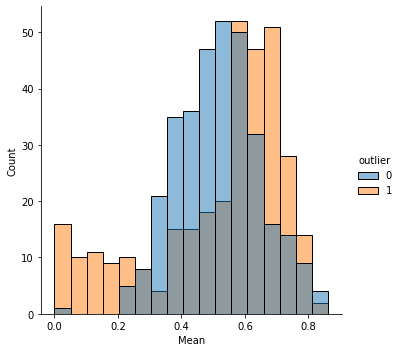

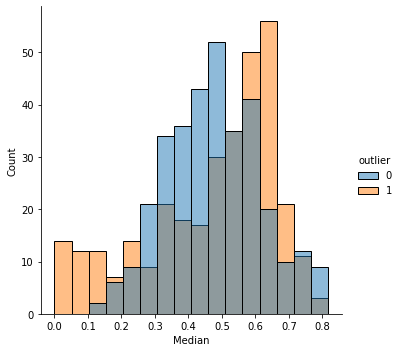

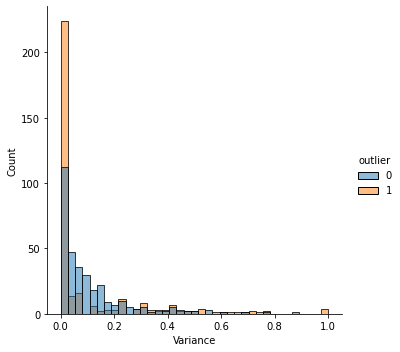

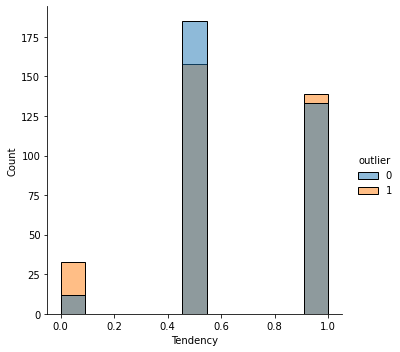

In [41]:
cols = df.columns.tolist()
i=0
cols.remove('outlier')

for col in cols:
  sns.displot(data=df_small, x=col, hue='outlier')
  i+=1
plt.show()

From the covariance matrix in profiling report we can conclude that the most important features for now are: `ASTV`, `ALTV`, `Mean`, `DP`, and from these plots we can see that all features has different distributions by target variable



## Preprocessor pipeline

This pipeline is designed for the both algorithms - supervised and unsupervised

In [42]:
num_cols  = set(df.columns) - set(trans_cols) - set(['outlier'])
num_cols = list(num_cols)

X = df.copy()
X.drop('outlier', axis=1, inplace=True)
print('Shape before the transformation:')
print(X.shape)

num_pipeline = Pipeline([
#    ('trans', QuantileTransformer()),
    ('scaler', StandardScaler()),
])

trans_pipeline = Pipeline([
    ('pow', PowerTransformer()),
    ('scaler', StandardScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
      ('num', num_pipeline, num_cols),
      ('trans', trans_pipeline, trans_cols),
    
])

pipeline = make_pipeline(
    preprocessor,
)

df_tr = pipeline.fit_transform(X)

print('Shape after the transformation:')
print(df_tr.shape)

Shape before the transformation:
(16880, 22)
Shape after the transformation:
(16880, 22)


## TSNE

Let's try to visualize the data

In [43]:
X = df_tr
y = df.outlier

tsne = TSNE(perplexity=100, metric='mahalanobis', n_components=3)
transformed_tsne = tsne.fit_transform(X)


In [44]:
fig = px.scatter_3d(
    transformed_tsne, x=1, y=0, z=2,
    color=df.outlier, labels={'color': 'outlier'}
)
fig.update_traces(marker_size=1)
fig.show()


We can see that the most outliers are located near the borders, but they overlap with normal data

# Unsupervised methods

In this part of the project we suppose that we don't know anything about `outlier` variable, even the amount of them. So for hyperparameter tuning and quality evaluation I will use metrics: Silhouette Coeficient, Calinski-Harabasz Index and Davies-Bouldin Index

## Scorers

Unfortunately only slihouette scorer is someho working =(

In [45]:
def silhouette_scorer(estimator, X):
    estimator.fit(X)
    labels = estimator.predict(X)
    labels = np.where(labels == -1, 1, 0)
    score = silhouette_score(X, labels)
    return score

In [46]:
def calinski_harabasz_scorer(estimator, X):
    estimator.fit(X)
    labels = estimator.predict(X)
    labels = np.where(labels == -1, 1, 0)
    score = calinski_harabasz_score(X, labels)
    return score

In [47]:
def davies_boldin_scorer(estimator, X):
    estimator.fit(X)
    labels = estimator.predict(X)
    labels = np.where(labels == -1, 1, 0)
    score = davies_boldin_score(X, labels)
    return 1 / score

In [48]:
def get_labels(estimator, X):
  labels = estimator.predict(X)
  labels = np.where(labels == -1, 1, 0)
  print(f'Number of outliers found:{labels.sum()}')
  return labels

## Mahalanobis distances

To use this metric we have to assume that we have multivariate normal distribution, which actually isn't true - many variables are not normally distributed. 

In [49]:
from scipy.spatial.distance import pdist, mahalanobis

covariance_inverse = np.linalg.inv(np.cov(df_tr.T))

df_tr = pd.DataFrame(df_tr)
mean_vector = df_tr.mean(axis=0)

bias_distance = df_tr.apply(lambda row:
                             mahalanobis(mean_vector, row, VI=covariance_inverse), 
                             axis=1)

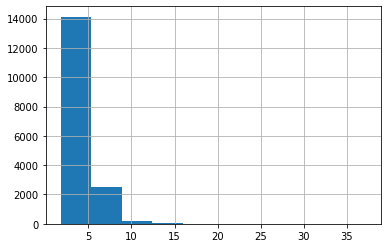

In [50]:
bias_distance.hist()
plt.show()

Let's get 2% tail region and compare with actual labels to measure the performance. If we would not knew about 2% we couls select standard p-value of 5% tail region for example.

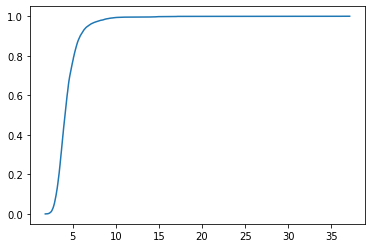

In [51]:
from statsmodels.distributions.empirical_distribution import ECDF

ecdf = ECDF(bias_distance)

plt.plot(ecdf.x, ecdf.y)
plt.show()

From the CDF plot we can see that roughly speaking distances more than 8 or 9 are the tail we need. The exact number, which we are going to use is:

In [52]:
np.percentile(bias_distance, 98)

8.31803057726067

In [53]:
predictions = np.zeros(df_tr.shape[0])
predictions[bias_distance >= 8.3] = 1
df['label_mahalanobis'] = predictions
df['distances'] = bias_distance
df.label_mahalanobis.value_counts()

0.0    16538
1.0      342
Name: label_mahalanobis, dtype: int64

We are going to use this labels and distances as an additional features.

In [54]:
print(classification_report(df.outlier, df.label_mahalanobis))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     16550
           1       0.16      0.17      0.17       330

    accuracy                           0.97     16880
   macro avg       0.57      0.58      0.57     16880
weighted avg       0.97      0.97      0.97     16880



As we can see, mahalanobis rule gave very poor result and it is not suitable for this data

## One class SVM

I have to repeat the part of pipeline to catch extra features

In [55]:
X = df.drop('outlier', axis=1)

print('Shape before the transformation:')
print(X.shape)

num_cols  = set(df.columns) - set(trans_cols) - set(['outlier'])
num_cols = list(num_cols)
print(num_cols)

preprocessor = ColumnTransformer(
    transformers=[
      ('num', num_pipeline, num_cols),
      ('trans', trans_pipeline, trans_cols),
    
])

pipeline = make_pipeline(
    preprocessor,
)

df_tr = pipeline.fit_transform(X)

print('Shape after the transformation:')
print(df_tr.shape)

Shape before the transformation:
(16880, 24)
['id', 'ASTV', 'FM', 'Max', 'Min', 'Width', 'DP', 'Median', 'Mean', 'ALTV', 'DL', 'Mode', 'Tendency', 'UC', 'DS', 'Nmax', 'LB', 'label_mahalanobis', 'distances', 'Nzeros']
Shape after the transformation:
(16880, 24)


In [56]:
svm = SGDOneClassSVM(nu=0.2, max_iter=4000, random_state=42)

svm.fit(df_tr)

labels = get_labels(svm, df_tr)

Number of outliers found:4982


The model found much more outliers than we have in reality. Let's see how it is comparable with true labels

In [57]:
print(classification_report(df.outlier, labels))

              precision    recall  f1-score   support

           0       0.98      0.70      0.82     16550
           1       0.01      0.20      0.02       330

    accuracy                           0.69     16880
   macro avg       0.50      0.45      0.42     16880
weighted avg       0.96      0.69      0.80     16880



We can see that scores are not great, let's try some HP tuning

In [58]:
svm = SGDOneClassSVM(random_state=42)

grid = {
    'nu': np.linspace(0.1,1,10),
    'average': [False, 2, 3, 4],
    'max_iter': [1000, 2000, 3000],
  }

gs = GridSearchCV(svm, grid, scoring=silhouette_scorer, cv=3)
gs.fit(df_tr)

GridSearchCV(cv=3, estimator=SGDOneClassSVM(random_state=42),
             param_grid={'average': [False, 2, 3, 4],
                         'max_iter': [1000, 2000, 3000],
                         'nu': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring=<function silhouette_scorer at 0x7ff335591af0>)

In [59]:
print(gs.best_estimator_)
print(f'Best score: {gs.best_score_:.3f}')

labels = get_labels(gs.best_estimator_, df_tr)

SGDOneClassSVM(nu=0.4, random_state=42)
Best score: 0.051
Number of outliers found:7296


In [60]:
print(classification_report(df.outlier, labels))

              precision    recall  f1-score   support

           0       0.97      0.56      0.71     16550
           1       0.01      0.21      0.02       330

    accuracy                           0.56     16880
   macro avg       0.49      0.39      0.37     16880
weighted avg       0.95      0.56      0.70     16880



We can see that if we optimize by Silhouette, we got just slightly better result. I tried other two scorers as well but to no avail =(

## Isolation Forest

In [61]:
ifor = IsolationForest(n_estimators=300, max_samples=0.1, contamination='auto',
                       max_features=0.8, bootstrap=False, n_jobs=-1, 
                       random_state=42, verbose=0, warm_start=False)

ifor.fit(df_tr)

labels = get_labels(ifor, df_tr)

Number of outliers found:891


In [62]:
print(classification_report(df.outlier, labels))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     16550
           1       0.14      0.38      0.21       330

    accuracy                           0.94     16880
   macro avg       0.56      0.67      0.59     16880
weighted avg       0.97      0.94      0.96     16880



This result is slightly better than one class SVM, but still not great

# Supervized methods

## Model evaluation func

In [63]:
def evaluate_model(pipeline, X_train, y_train, X_test, y_test, cv):

  scorers = {
              'f1_score': make_scorer(f1_score, average='micro'),
              'precision_score': make_scorer(precision_score, average='micro'),
              'recall_score': make_scorer(recall_score, average='micro'),
              'accuracy_score': make_scorer(accuracy_score)
            }

  results = cross_validate(estimator=pipeline, X=X_train, y=y_train, cv=cv, scoring=scorers['f1_score'], return_train_score=True, error_score="raise")

  ppl = pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)

  train_score = results['train_score']
  val_score = results['test_score']

  print(f'\nTrain f1: {train_score.mean():.3f}, Std: {train_score.std():.3f}')
  print(f'Validation f1: {val_score.mean():.3f}, Std: {val_score.std():.3f}')
  print(f'Test f1: {f1_score(y_test, y_pred):.3f}')

  print(classification_report(y_test, y_pred))

  return pipeline

## Preprocessor pipeline

In [64]:
#num_cols  = set(df.columns) - set(trans_cols) - set(['outlier'])
#num_cols = list(num_cols)

#X = df.drop('outlier', axis=1)
#y = df.outlier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,\
                                                    stratify=y, random_state=42)

print('Shape before the transformation:')
print(X_train.shape)
print(X_train.columns)

X_train_tr = pipeline.fit_transform(X_train)
X_test_tr = pipeline.transform(X_test)

print('Shape after the transformation:')
print(X_train_tr.shape)

Shape before the transformation:
(11816, 24)
Index(['id', 'LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL',
       'DS', 'DP', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
       'Median', 'Variance', 'Tendency', 'label_mahalanobis', 'distances'],
      dtype='object')
Shape after the transformation:
(11816, 24)


## SVM

In [65]:
%%time 

#from sklearn.pipeline import make_pipeline

def objective(space):
    params = {
        'C': round(space['C'], 3),
        'kernel': space['kernel'],
        'degree' : space['degree'],
        'gamma': space['gamma']
    }
    
    clf = SVC(
        class_weight='balanced', 
        random_state=42,
        **params
    )

    ppl = make_pipeline(
        preprocessor,
        SMOTE(),
        PolynomialFeatures(2),
        clf,
    )    

    f1_scorer = make_scorer(f1_score, average='micro')
    
    score = cross_val_score(ppl, X_train, y_train, scoring=f1_scorer, cv=5).mean()
    print("score {:.3f} params {}".format(score, params))
    return {'loss':1 - score, 'status': STATUS_OK }

space = {
      'C': hp.uniform('C',0.1, 100),
      'kernel': hp.choice('kernel', ['poly', 'rbf', 'sigmoid']), 
      'degree': hp.choice('degree', [3, 4, 5, 6]), 
      'gamma': hp.choice('gamma', ['scale', 1, 0.1, 0.01, 0.001]),
      
    }

'''best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)'''

CPU times: user 1.51 ms, sys: 0 ns, total: 1.51 ms
Wall time: 1.57 ms


'best = fmin(fn=objective,\n            space=space,\n            algo=tpe.suggest,\n            max_evals=10)'

In [66]:
#best

### best

In [67]:
svm = SVC(C=11, kernel='poly', degree=4, gamma=1, class_weight='balanced', random_state=42)

ppl = make_pipeline(
    preprocessor,
    svm,
)

ppl = evaluate_model(ppl, X_train, y_train, X_test, y_test, 3)


Train f1: 1.000, Std: 0.000
Validation f1: 0.991, Std: 0.004
Test f1: 0.721
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4965
           1       0.66      0.80      0.72        99

    accuracy                           0.99      5064
   macro avg       0.83      0.89      0.86      5064
weighted avg       0.99      0.99      0.99      5064



not bad result, let's try with polynomial features

### best + poly

In [68]:
svm = SVC(C=47, kernel='poly', degree=3, gamma=0.1, class_weight='balanced', random_state=42)

ppl = make_pipeline(
    preprocessor,
    PolynomialFeatures(2),
    svm,
)

ppl = evaluate_model(ppl, X_train, y_train, X_test, y_test, 3)


Train f1: 1.000, Std: 0.000
Validation f1: 0.991, Std: 0.005
Test f1: 0.774
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4965
           1       0.77      0.78      0.77        99

    accuracy                           0.99      5064
   macro avg       0.88      0.89      0.88      5064
weighted avg       0.99      0.99      0.99      5064



Polynomial features gave better results. Let's try oversampling

### best + poly + smote

In [69]:
svm = SVC(C=47, kernel='poly', degree=3, gamma=0.1, class_weight='balanced', random_state=42)

ppl = make_pipeline(
    preprocessor,
    PolynomialFeatures(2),
    SMOTE(),
    svm,
)

ppl = evaluate_model(ppl, X_train, y_train, X_test, y_test, 3)


Train f1: 1.000, Std: 0.000
Validation f1: 0.990, Std: 0.006
Test f1: 0.757
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4965
           1       0.70      0.82      0.76        99

    accuracy                           0.99      5064
   macro avg       0.85      0.91      0.88      5064
weighted avg       0.99      0.99      0.99      5064



SMOTE shows unstable result in each run - sometimes better, sometimes worse. 

## Logreg

In [70]:
%%time 

def objective(space):
    params = {
        'penalty': space['penalty'],
        'C': round(space['C'], 3),
        'solver': space['solver'],
        'max_iter' : space['max_iter'],
        'l1_ratio': round(space['l1_ratio'], 3),
    }
    
    clf = LogisticRegression(
        class_weight='balanced', 
        random_state=42,
        multi_class='ovr',
        n_jobs=-1,
        **params
    )

    ppl = make_pipeline(
        preprocessor,
        PolynomialFeatures(2),
        clf,
    )    

    f1_scorer = make_scorer(f1_score, average='micro')
    
    score = cross_val_score(ppl, X_train, y_train, scoring=f1_scorer, cv=5).mean()
    print("score {:.3f} params {}".format(score, params))
    return {'loss':1 - score, 'status': STATUS_OK }

space = {
      'penalty': hp.choice('penalty', ['l1', 'l2', 'elasticnet', None]),
      'C': hp.uniform('C',0.1, 100),
      'solver': hp.choice('solver', ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']), 
      'max_iter': hp.choice('max_iter', [100, 500, 1000]),
      'l1_ratio': hp.uniform('l1_ratio',0,1),
    }

'''best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)'''

CPU times: user 757 µs, sys: 4 µs, total: 761 µs
Wall time: 775 µs


'best = fmin(fn=objective,\n            space=space,\n            algo=tpe.suggest,\n            max_evals=10)'

In [74]:
#score 0.994 params {'penalty': 'l1', 'C': 98.058, 'solver': 'liblinear', 'max_iter': 1000, 'l1_ratio': 0.073}

logreg = LogisticRegression(C=98, penalty='l1', class_weight='balanced',
                            solver='liblinear', max_iter=1000,  l1_ratio=0.073,
                            random_state=42)

ppl = make_pipeline(
    preprocessor,
    PolynomialFeatures(2),
    SMOTE(),
    logreg,
)

ppl = evaluate_model(ppl, X_train, y_train, X_test, y_test, 3)


Train f1: 1.000, Std: 0.000
Validation f1: 0.991, Std: 0.000
Test f1: 0.848
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4965
           1       0.85      0.85      0.85        99

    accuracy                           0.99      5064
   macro avg       0.92      0.92      0.92      5064
weighted avg       0.99      0.99      0.99      5064

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['id', 'ASTV', 'FM', 'Max',
                                                   'Min', 'Width', 'DP',
                                                   'Median', 'Mean', 'ALTV',
                                                   'DL', 'Mode', 'Tendency',
                               

Result is better then SVM

## KNN

In [72]:
%%time 

def objective(space):
    params = {
        'n_neighbors': space['n_neighbors'],
        'algorithm': space['algorithm'],
        'metric' : space['metric'],
    }
    
    clf = KNeighborsClassifier(
        n_jobs=-1,
        **params
    )

    ppl = make_pipeline(
        preprocessor,
        clf,
    )    

    f1_scorer = make_scorer(f1_score, average='micro')
    
    score = cross_val_score(ppl, X_train, y_train, scoring=f1_scorer, cv=5).mean()
    print("score {:.3f} params {}".format(score, params))
    return {'loss':1 - score, 'status': STATUS_OK }

space = {
      'n_neighbors': hp.choice('n_neighbors', [2, 4, 6, 8]),
      'algorithm': hp.choice('algorithm', ['ball_tree', 'kd_tree', 'brute']), 
      'metric': hp.choice('metric', ['cityblock', 'cosine', 'euclidean', 'haversine', 'l1', 'l2', ]), 
    }

#best = fmin(fn=objective,
#            space=space,
#            algo=tpe.suggest,
#            max_evals=10)

CPU times: user 2.05 ms, sys: 1e+03 µs, total: 3.05 ms
Wall time: 6.24 ms


In [73]:
clf = KNeighborsClassifier(
    n_jobs=-1,
    n_neighbors=2,
    algorithm='auto',
    metric='cosine'
)

ppl = make_pipeline(
    preprocessor,
#    PolynomialFeatures(2),
    SMOTE(),
    clf,
)    

ppl = evaluate_model(ppl, X_train, y_train, X_test, y_test, 3)


Train f1: 1.000, Std: 0.000
Validation f1: 0.996, Std: 0.001
Test f1: 0.914
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4965
           1       0.98      0.86      0.91        99

    accuracy                           1.00      5064
   macro avg       0.99      0.93      0.96      5064
weighted avg       1.00      1.00      1.00      5064



Polynomial features decreased the scores for the KNN. So far the best. 

# Conclusion

From unsupervised algorithms the best was Isolation Forest which was able to catch some true outliers, but performance is very low. Contrary to that supervised learning algorithms gave a good results with the best from KNN. So my conclusion is to try make at lest some labels to the data, it increases the performance drastically. Let's see the feature importances using simple model without polynomial features (I could not get names out after PlynomialFeatures)

In [98]:
dtr = DecisionTreeClassifier(
    criterion='gini', 
    splitter='best', 
    max_depth=25, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features=0.8, 
    random_state=42, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight='balanced',
    ccp_alpha=0.0
    )

ppl = make_pipeline(
    preprocessor,
    SMOTE(),
    dtr,
)    

ppl = evaluate_model(ppl, X_train, y_train, X_test, y_test, 3)


Train f1: 1.000, Std: 0.000
Validation f1: 0.993, Std: 0.001
Test f1: 0.882
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4965
           1       0.90      0.87      0.88        99

    accuracy                           1.00      5064
   macro avg       0.95      0.93      0.94      5064
weighted avg       1.00      1.00      1.00      5064



Performance is good enough

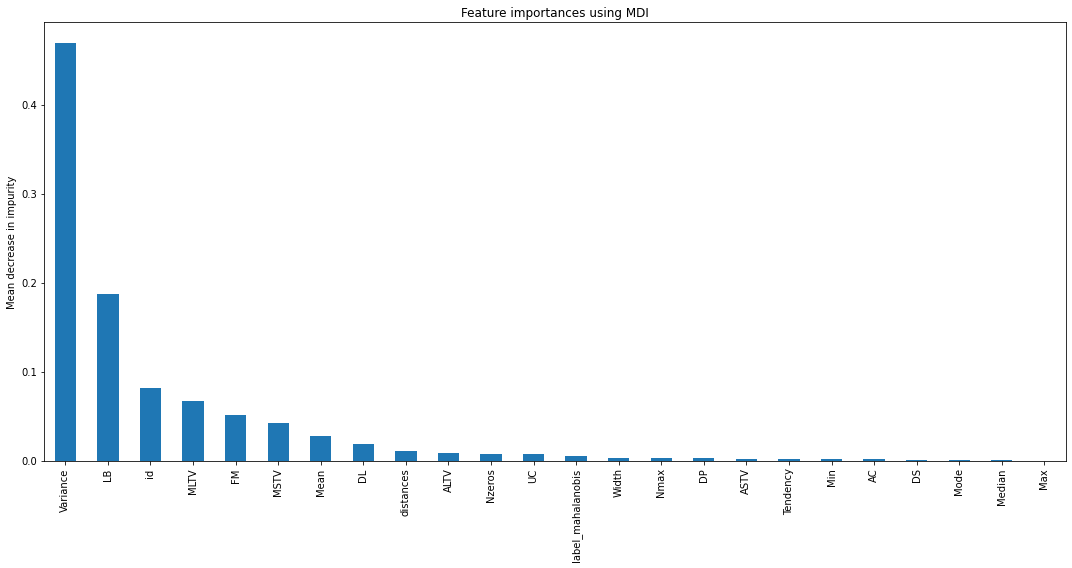

In [95]:
feature_names = X_train.columns
feature_importances = ppl['decisiontreeclassifier'].feature_importances_

forest_importances = pd.Series(feature_importances, index=feature_names)

fig, ax = plt.subplots(figsize=(15,8))
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

So from the graph we can see that the most important features are: `Variance` and `LB`. I can not tell anything about interactions between variables because I don't know how to get feature names out after PolynomialFeatures. If you have any idea please let me know. 